<table width="100%" border="3">
  <tbody>
    <tr>
      <td width=120><img src="https://is4-ssl.mzstatic.com/image/thumb/Purple128/v4/9f/38/cb/9f38cb51-c606-6fd4-54b3-47bfdb06b712/source/256x256bb.jpg" alt="Aidea" width="120"/></td>
      <td align='left'><h1>TensorFlow 2 Object Detection</h1><BR><h2>D1-UseTF2ObjectDetectionModel</h2></td>
    </tr>
  </tbody>
</table>

# Part 1: 設定Colab環境來執行Object Detection API with TensorFlow 2


## Step 1: 設定雲端硬碟

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


## Step 2: 將工作目錄移到雲端硬碟

In [ ]:
from os import chdir
chdir("/content/drive/My Drive/")

## Step 3: 用Git clone指令下載Object Detection API 

In [ ]:
!git clone https://github.com/tensorflow/models

In [ ]:
!ls /content/drive/MyDrive/models/research

adversarial_text
attention_ocr
audioset
autoaugment
cognitive_planning
content
cvt_text
data
deeplab
deep_speech
delf
efficientdet_d0_coco17_tpu-32
efficientdet_d0_mbsh
efficientdet_d0_mbsh.zip
efficient-hrl
generate_tfrecord.py
lfads
lstm_object_detection
marco
mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8
mbsh
model
model613
model613A
nst_blogpost
object_detection
pcl_rl
pet-detection
README.md
rebar
seq_flow_lite
slim
submission-example
test_cdc
train_cdc
vid2depth
xml_to_csv.py


## Step 4: 清除多餘的git設定

In [ ]:
%%bash
cd models
rm -rf .git

## Step 5: 安裝套件

In [ ]:
!pip install tf_slim
!pip install lvis
!pip install tensorflow-addons

     |████████████████████████████████| 358kB 28.4MB/s 
     |████████████████████████████████| 686kB 23.3MB/s 


## Step 6: 設定工作環境

In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [ ]:
%env PYTHONPATH=/env/python:/content/drive/My Drive/models:/content/drive/My Drive/models/research:/content/drive/My Drive/models/research/slim

env: PYTHONPATH=/env/python:/content/drive/My Drive/models:/content/drive/My Drive/models/research:/content/drive/My Drive/models/research/slim


In [ ]:
import sys
sys.path.append('/content/drive/My Drive/models')

In [ ]:
from os import chdir
chdir("/content/drive/My Drive/models/research/")

## Step 7: 測試Object Detection套件


In [ ]:
!python object_detection/builders/model_builder_tf2_test.py

2021-06-17 02:26:42.717045: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-06-17 02:27:30.407026: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-06-17 02:27:30.474621: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-06-17 02:27:30.474710: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (6ef3b1c074a4): /proc/driver/nvidia/version does not exist
W0617 02:27:30.833015 140667610683264 model_builder.py:1085] Building experimental DeepMAC meta-arch. Some features may be omitted.
INFO:tensorflow:time(__main__.ModelBuilderTF2Test.test_create_center_net_deepmac): 0.82s
I0617 02:27

# Part 2: 測試物件偵測

## Step 1: 從TensorFlow網站下載由CoCo預訓練的物件偵測模型
https://cocodataset.org/

https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md

In [ ]:
%%bash
wget http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d0_coco17_tpu-32.tar.gz
tar -xvf efficientdet_d0_coco17_tpu-32.tar.gz
rm -rf efficientdet_d0_coco17_tpu-32.tar.gz

In [ ]:
!pwd

/content/drive/My Drive/models/research


In [ ]:
!ls

adversarial_text
attention_ocr
audioset
autoaugment
cognitive_planning
cvt_text
data
deeplab
deep_speech
delf
efficientdet_d0_coco17_tpu-32
efficient-hrl
generate_tfrecord.py
lfads
lstm_object_detection
marco
mask_rcnn_inception_resnet_v2_1024x1024_coco17_gpu-8
model
nst_blogpost
object_detection
pcl_rl
README.md
rebar
seq_flow_lite
slim
vid2depth
xml_to_csv.py


## Step 2: 設定執行環境所需的函數庫


In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  #Load an image from file into a numpy array.
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  image = image.convert("RGB")
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

def get_keypoint_tuples(eval_config):
  """Return a tuple list of keypoint edges from the eval config.
  
  Args:
    eval_config: an eval config containing the keypoint edges
  
  Returns:
    a list of edge tuples, each in the format (start, end)
  """
  tuple_list = []
  kp_list = eval_config.keypoint_edge
  for edge in kp_list:
    tuple_list.append((edge.start, edge.end))
  return tuple_list

## Step 3: 設定模型

In [ ]:
import os
pipeline_config = 'efficientdet_d0_coco17_tpu-32/pipeline.config'
model_dir = 'efficientdet_d0_coco17_tpu-32/checkpoint'

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(pipeline_config)

In [ ]:
def get_model_detection_function(model):
  """Get a tf.function for detection."""
  @tf.function
  def detect_fn(image):
    """Detect objects in image."""
    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)
    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

In [ ]:
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)
detect_fn = get_model_detection_function(detection_model)

In [ ]:
# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(model_dir, 'ckpt-0')).expect_partial()

In [ ]:
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

## Step 4: 讀入影像檔和轉換成Tensor

In [ ]:
image_dir = 'object_detection/test_images/'
image_path = os.path.join(image_dir, 'image3.jpg')
image_np = load_image_into_numpy_array(image_path)

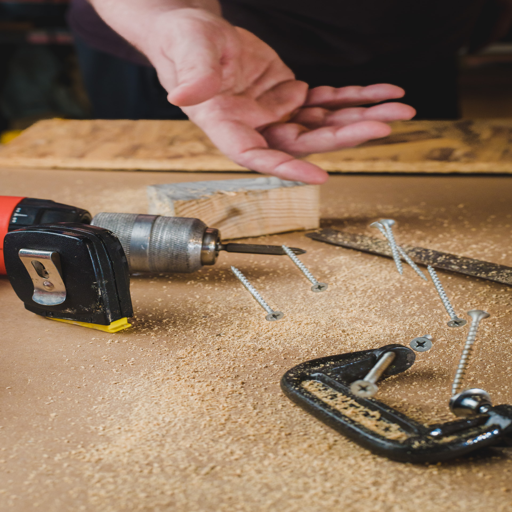

In [ ]:
test_image = Image.open(image_path)
test_image=test_image.resize((512, 512))
display(test_image)

In [ ]:
image_np.shape

(636, 1024, 3)

In [ ]:
input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)

In [ ]:
input_tensor.shape

TensorShape([1, 636, 1024, 3])

In [ ]:
type(input_tensor)

tensorflow.python.framework.ops.EagerTensor

## Step 5: 執行物件偵測


In [ ]:
detections, predictions_dict, shapes = detect_fn(input_tensor)

In [ ]:
print(detections["detection_scores"])

tf.Tensor(
[[0.84045315 0.62717295 0.47300404 0.38980985 0.36178625 0.3421171
  0.2277948  0.21835732 0.20259443 0.1943095  0.17641562 0.17595986
  0.16683778 0.16552535 0.1647931  0.1600968  0.15857318 0.15298903
  0.15220147 0.15126383 0.14985532 0.14648208 0.13031128 0.12531352
  0.12370199 0.120949   0.11863372 0.11555535 0.1144     0.11328056
  0.10745671 0.10604346 0.10541356 0.10449734 0.10078591 0.09842283
  0.09670511 0.09580219 0.09300795 0.08990127 0.08931935 0.08725032
  0.08697659 0.08685991 0.0868113  0.08503598 0.08445817 0.08231232
  0.08166933 0.08140934 0.08092505 0.08030683 0.08006549 0.07963613
  0.07928884 0.07761502 0.07746187 0.07727972 0.07689273 0.07686171
  0.07624468 0.0762417  0.07588679 0.075674   0.07319817 0.07318988
  0.0720042  0.07158372 0.07124174 0.07014567 0.0697698  0.06975085
  0.069599   0.06953764 0.06899369 0.06801566 0.06774285 0.06754518
  0.06747785 0.06634551 0.06633994 0.06629455 0.06625834 0.06620824
  0.06606871 0.06606591 0.06527928 0.0

## Step 6: 檢視物件偵測結果

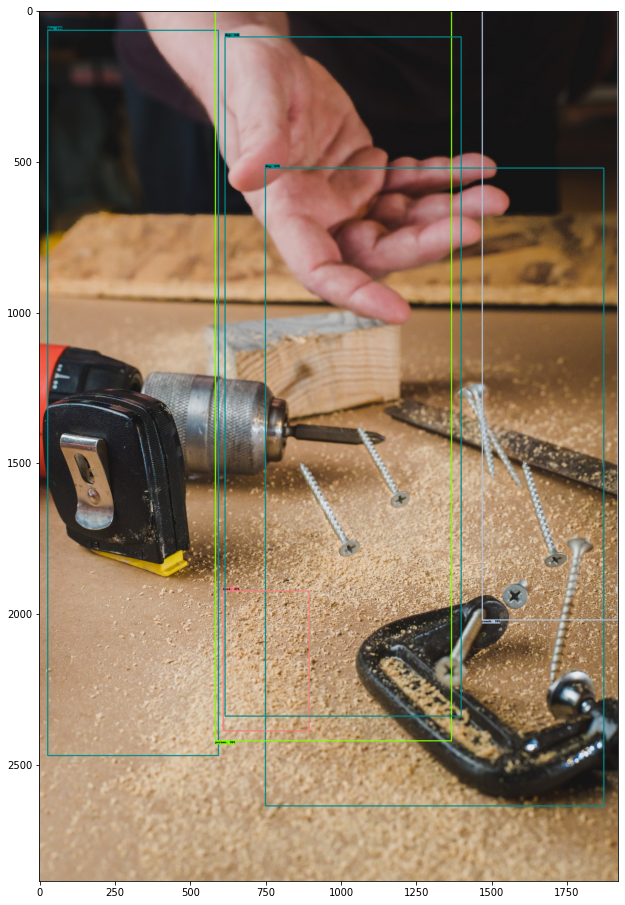

In [ ]:
label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()